In [1]:
import requests
import pandas as pd
import yfinance as yf
pd.set_option('display.max_rows', None)


url = "https://en.wikipedia.org/wiki/List_of_S%26P_600_companies" 


def read_html_from_website(url):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        
        # Check if request was successful
        if response.status_code == 200:
            # Extract HTML content from the response
            html_content = response.text
            return html_content
        else:
            print("Failed to retrieve HTML. Status code:", response.status_code)
            return None
    except Exception as e:
        print("An error occurred:", e)
        return None

# # # Create 

html_content = read_html_from_website(url)
list_df = pd.read_html(html_content)
df = list_df[0]
df = df.drop(columns=["SEC filings","CIK"])
df = df.dropna()
#df = df.head(20)
df


,Symbol,Company,GICS Sector,GICS Sub-Industry,Headquarters Location
0,AAON,"AAON, Inc.",Industrials,Building Products,"Tulsa, Oklahoma"
1,AAP,"Advance Auto Parts, Inc.",Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina"
2,AAT,American Assets Trust,Real Estate,Diversified REITs,"San Diego, California"
3,ABCB,Ameris Bancorp,Financials,Regional Banks,"Atlanta, Georgia"
4,ABG,Asbury Automotive Group,Consumer Discretionary,Automotive Retail,"Duluth, Georgia"
5,ABM,"ABM Industries, Inc.",Industrials,Environmental & Facilities Services,"New York City, New York"
6,ABR,Arbor Realty Trust,Financials,Mortgage REITs,"Uniondale, New York"
7,ACA,"Arcosa, Inc.",Industrials,Industrial Machinery,"Dallas, Texas"
8,ACIW,ACI Worldwide,Information Technology,Application Software,"Miami, Florida"
9,ACLS,"Axcelis Technologies, Inc.",Information Technology,Semiconductor Equipment,"Beverly, Massachusetts"


In [ ]:
import pandas as pd
import yfinance as yf

# Assuming you have an existing DataFrame named df with a column 'Symbol' containing tickers

# Iterate through each row using iterrows()
for index, row in df.iterrows():
    ticker = row['Symbol']  # Extract ticker from the current row

    # Get financial data using yfinance
    ticker_obj = yf.Ticker(ticker)

    try:
        # Get desired financial information
        total_assets = ticker_obj.balance_sheet.T['Total Assets'].iloc[0]
        total_debt = ticker_obj.balance_sheet.T['Total Debt'].iloc[0]
        total_revenue = ticker_obj.income_stmt.T['Total Revenue'].iloc[0]
        net_income = ticker_obj.income_stmt.T['Net Income'].iloc[0]
        current_liabilities = ticker_obj.balance_sheet.T['Current Liabilities'].iloc[0]
        current_assets = ticker_obj.balance_sheet.T['Current Assets'].iloc[0]
        inventory = ticker_obj.balance_sheet.T['Inventory'].iloc[0]

        # Check for incomplete data
        if any(pd.isnull(value) for value in [total_assets, total_debt, total_revenue, net_income, current_liabilities, current_assets, inventory]):
            print(f"{ticker} removed from df: Incomplete data")
            df = df[df['Symbol'] != ticker]  # Remove ticker from DataFrame
            continue  # Skip to the next iteration if data is incomplete

        # Calculate derived metrics
        debt_ratio = total_debt / total_assets
        calculated_profit_margin = net_income / total_revenue
        asset_turnover_ratio = total_revenue / total_assets
        liquidity_ratio = current_assets / current_liabilities
        quick_ratio = (current_assets - inventory) / current_liabilities

        # Add calculated metrics to DataFrame
        df.loc[index, 'Total Assets'] = total_assets
        df.loc[index, 'Total Debt'] = total_debt
        df.loc[index, 'Debt Ratio'] = debt_ratio
        df.loc[index, 'Total Revenue'] = total_revenue
        df.loc[index, 'Net Income'] = net_income
        df.loc[index, 'Inventory'] = inventory
        df.loc[index, 'Calculated Profit Margin'] = calculated_profit_margin
        df.loc[index, 'Asset Turnover Ratio'] = asset_turnover_ratio
        df.loc[index, 'Current Liabilities'] = current_liabilities
        df.loc[index, 'Current Assets'] = current_assets
        df.loc[index, 'Liquidity Ratio'] = liquidity_ratio
        df.loc[index, 'Quick Ratio'] = quick_ratio

    except KeyError:
        print(f"Error: Missing data for ticker {ticker}")
        
        df = df[df['Symbol'] != ticker] 

# Print or save the updated DataFrame
df

# df.to_csv("updated_financial_data.csv", index=False)  
# Example to save as CSV


In [ ]:
import yfinance as yf
ticker_object = yf.Ticker('AAON')
balancesheet = ticker_object.balance_sheet
print(balancesheet)

In [4]:
pd.set_option('display.max_rows', None)

C:\Users\tom77\AppData\Local\Temp\ipykernel_39652\3679659421.py:53: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(sector_avg_turnover, linefmt='b-', markerfmt='bo', basefmt='k-', use_line_collection=True)  # Using stem plot


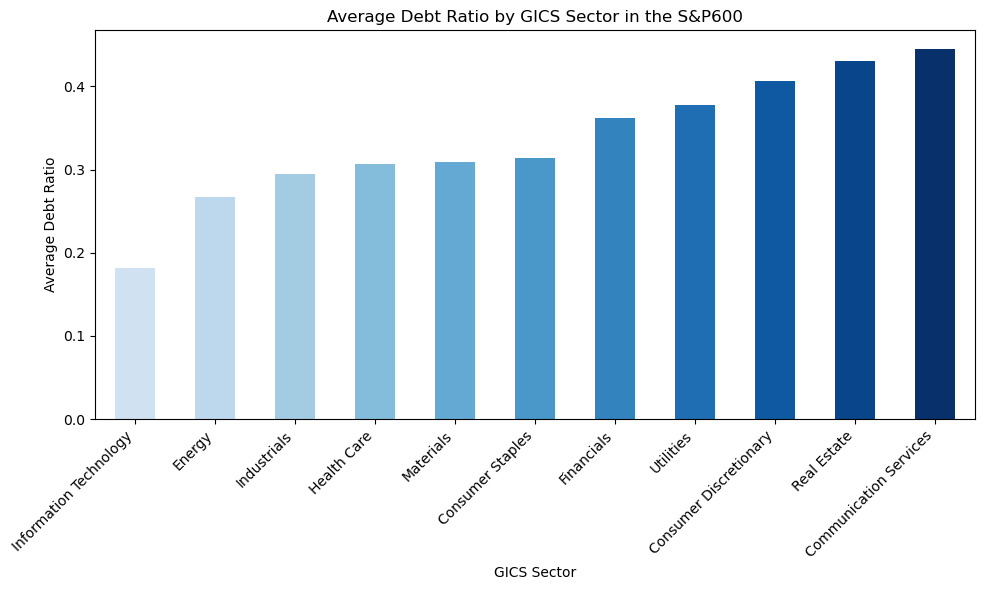

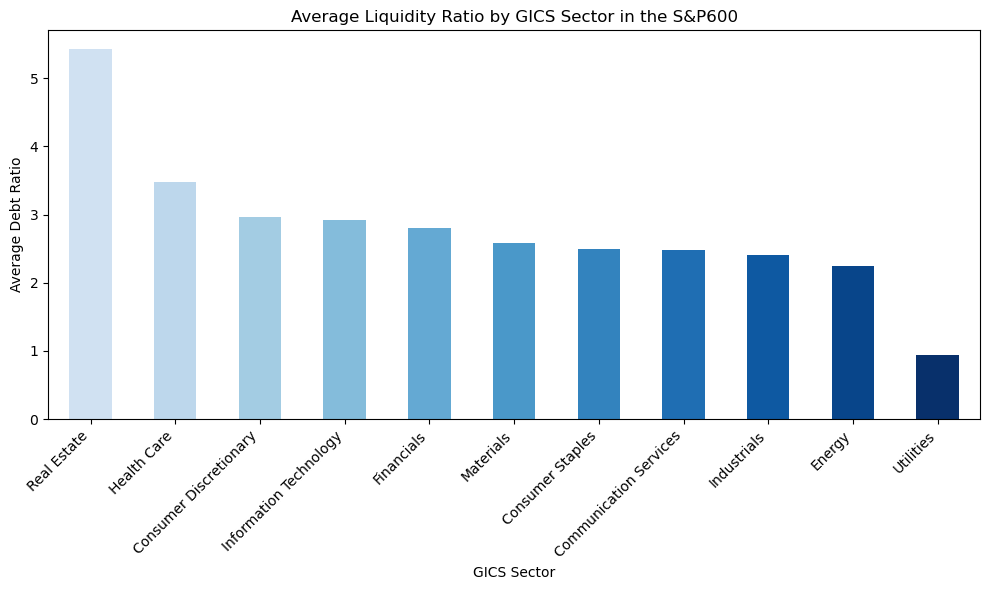

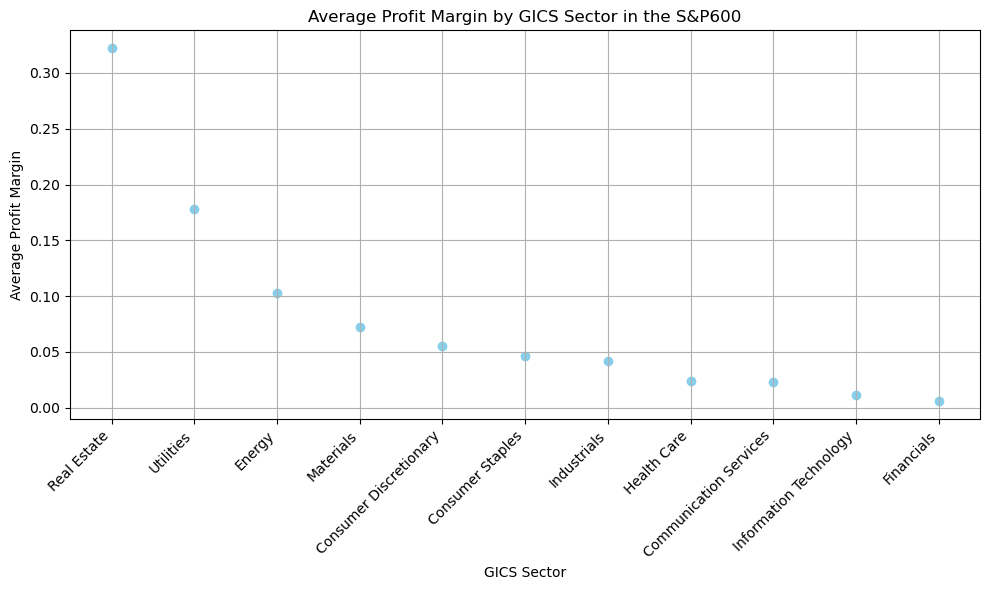

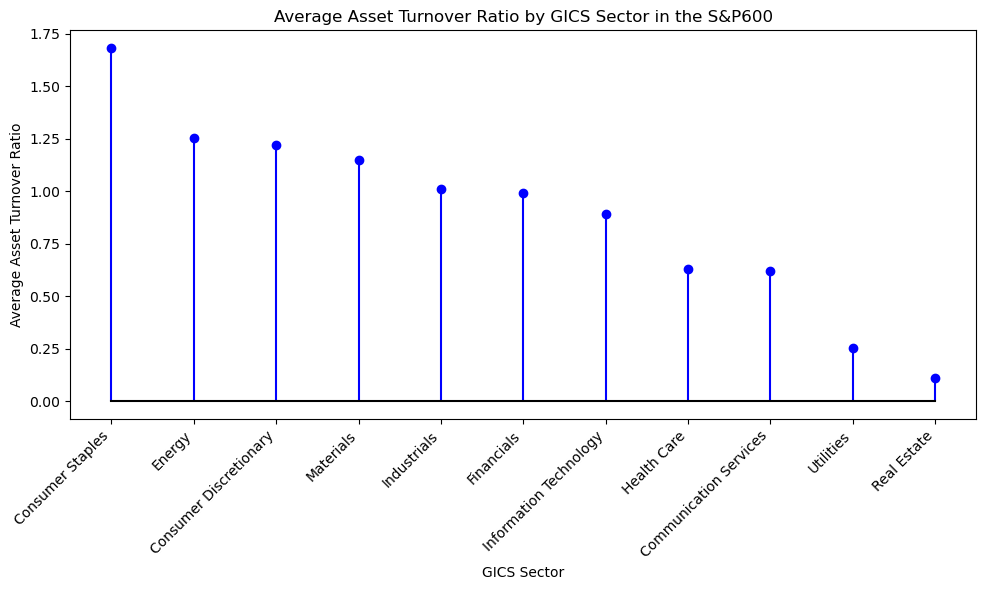

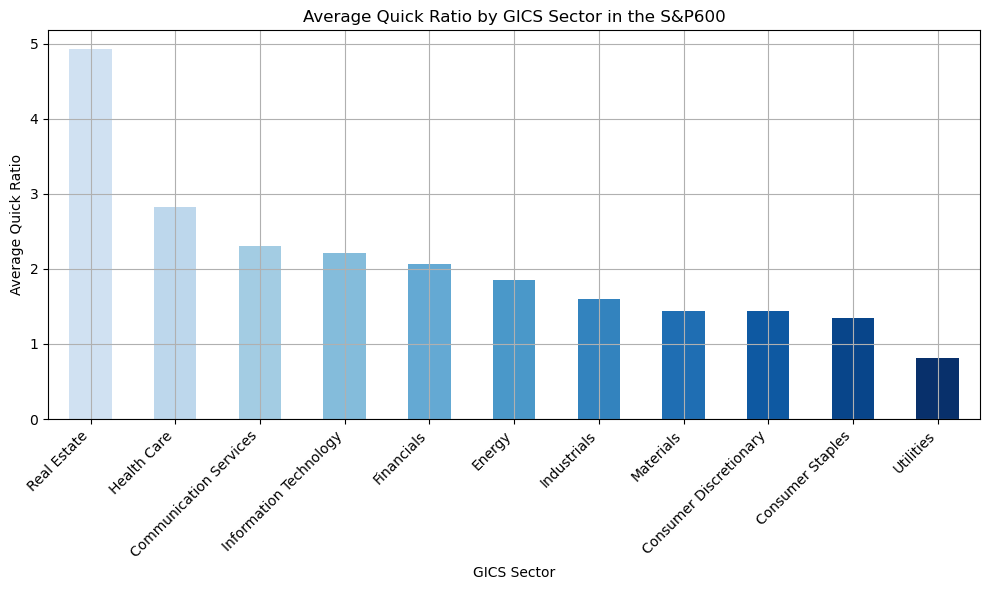

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define color palette for more variety
num_sectors = len(df['GICS Sector'].unique())
colors = plt.cm.Purples(np.linspace(0.2, 1, num_sectors))

# Plot Debt ratio graph
plt.figure(figsize=(10, 6))
sector_avg_debt_ratio = df.groupby('GICS Sector')["Debt Ratio"].mean().sort_values(ascending=True)
sector_avg_debt_ratio.plot(kind='bar', color=colors[:len(sector_avg_debt_ratio)])
plt.title("Average Debt Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Debt Ratio")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plot_debt_ratio.png')

# Plot liquidity ratio graph
plt.figure(figsize=(10, 6))
sector_avg_liquidity = df.groupby('GICS Sector')["Liquidity Ratio"].mean().sort_values(ascending=False)
sector_avg_liquidity.plot(kind='bar', color=colors[:len(sector_avg_liquidity)])
plt.title("Average Liquidity Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Debt Ratio")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plot_liquidity_ratio.png')

# Plot profit margin graph


plt.figure(figsize=(10, 6))
sector_avg_profit = df.groupby('GICS Sector')["Calculated Profit Margin"].mean().sort_values(ascending=False)

# Extracting x and y values for scatter plot
x = range(len(sector_avg_profit))
y = sector_avg_profit.values

plt.scatter(x, y, color='skyblue')  # Scatter plot instead of line plot
plt.title("Average Profit Margin by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Profit Margin")
plt.xticks(x, sector_avg_profit.index, rotation=45, ha='right')  # Using sector names as x ticks
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_profit_margin.png')


plt.figure(figsize=(10, 6))
sector_avg_turnover = df.groupby('GICS Sector')["Asset Turnover Ratio"].mean().sort_values(ascending=False)

plt.stem(sector_avg_turnover, linefmt='b-', markerfmt='bo', basefmt='k-', use_line_collection=True)  # Using stem plot
plt.title("Average Asset Turnover Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Asset Turnover Ratio")

# Using actual GICS sector column names as x-axis labels
plt.xticks(range(len(sector_avg_turnover)), sector_avg_turnover.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('plot_asset_turnover_ratio.png')

# Plot quick ratio graph
plt.figure(figsize=(10, 6))
sector_avg_quick = df.groupby('GICS Sector')["Quick Ratio"].mean().sort_values(ascending=False)
sector_avg_quick.plot(kind='bar', color=colors[:len(sector_avg_quick)])
plt.title("Average Quick Ratio by GICS Sector in the S&P600")
plt.xlabel('GICS Sector')
plt.ylabel("Average Quick Ratio")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.savefig('plot_quick_ratio.png')
